In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# Defininimos función para mostrar imágenes
def imshow(img, new_fig=True, title=None, color_img=False, blocking=False, colorbar=True, ticks=False):
    if new_fig:
        plt.figure()
    if color_img:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    #plt.title(title)
    if not ticks:
        plt.xticks([]), plt.yticks([])
    if colorbar:
        plt.colorbar()
    if new_fig:        
        plt.show(block=blocking)

In [11]:
def encontrar_patente(img_bin, img):
    ext_contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_out = img.copy()
    cv2.drawContours(img_out, ext_contours, -1, (255,0,0), 2)
    height, width = img.shape[:2]
    #imshow(img_out, title="Contorno exterior")
    posibles_patentes = []
    for c in ext_contours:
        # Aproximar el contorno a un polígono
        epsilon = 0.045 * cv2.arcLength(c, True)  # Ajusta 0.02 según lo necesario
        approx = cv2.approxPolyDP(c, epsilon, True)
        area = cv2.contourArea(c)
        # Verificar si el polígono tiene 4 vértices
        x, y, w, h = cv2.boundingRect(c)
        if len(approx) == 4 and 42 < w < 103 and 11<h<46:
            # Dibujar el contorno del rectángulo
            cv2.drawContours(img_out, [c], -1, (0, 255, 0), 2)
            # Ajustar las coordenadas del recorte
            y_start = max(0, y - int(h * 0.3))  # Margen superior (máximo 0)
            y_end = min(height, y + h + int(h * 0.2))  # Margen inferior (máximo altura total)
            patente = img[y_start:y_end, x:x+w]
            posibles_patentes.append(patente)
            # Calcular el rectángulo delimitador y dibujarlo (opcional)            
            cv2.rectangle(img_out, (x, y), (x + w, y + h), (0, 0, 255), 2)
    imshow(img_out)
    return posibles_patentes

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\franco\AppData\Local\Temp\ipykernel_13764\3868851287.py:1: SyntaxWarning: invalid escape sequence '\i'
  img = cv2.imread('archivos\img12.png')


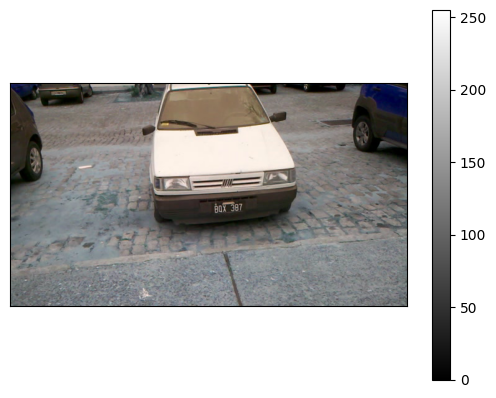

In [54]:
img = cv2.imread('archivos\img12.png')
imshow(img)

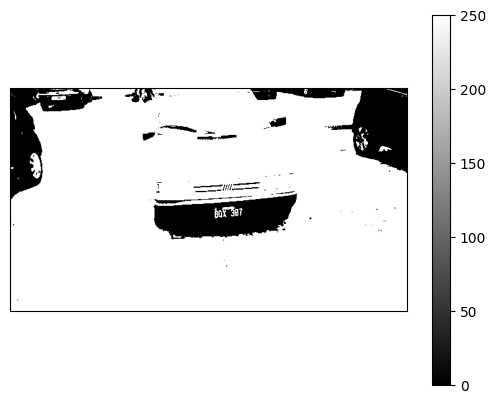

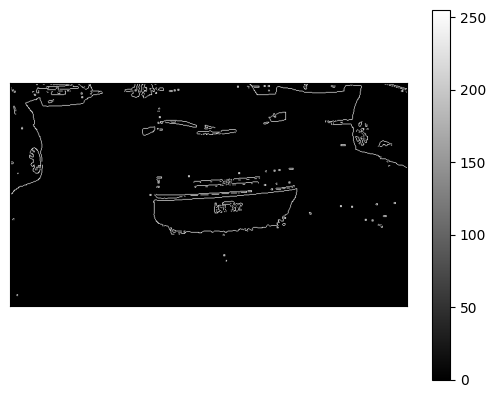

In [55]:
w = 4
h = 9
img_gray = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
_,img_bin = cv2.threshold(img_gray.copy(),63,250, type=cv2.THRESH_BINARY)
img_canny = cv2.Canny(img_bin, 200,350)
imshow(img_bin)
imshow(img_canny)

In [56]:
s = cv2.getStructuringElement(cv2.MORPH_RECT, (h,w))

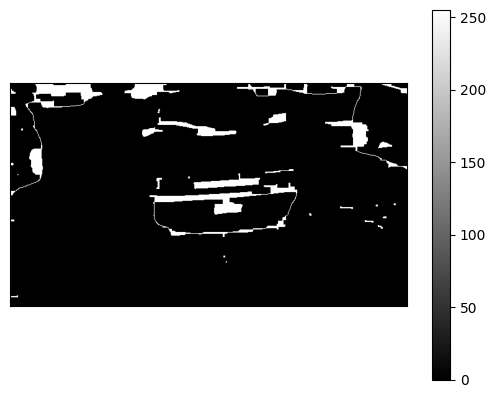

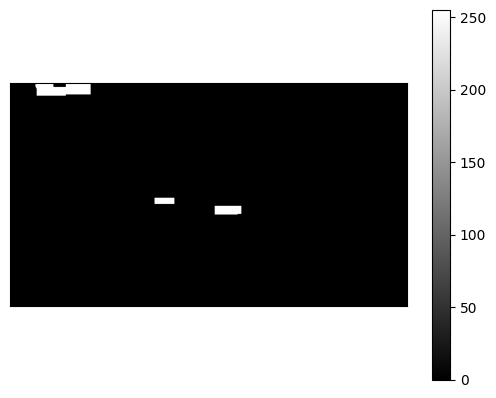

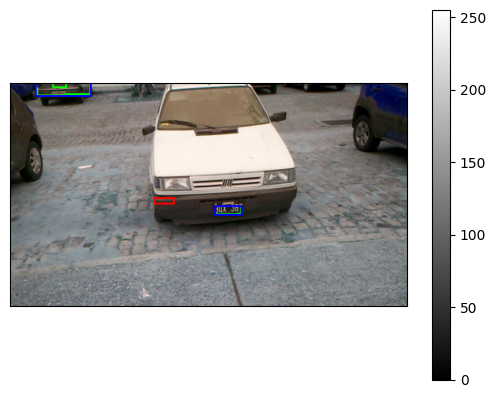

In [57]:
posibles_patentes = []
img_close = cv2.morphologyEx(img_canny.copy(), cv2.MORPH_CLOSE, s, iterations=2)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_close, connectivity=8)
filtered_img = np.zeros_like(img_close, dtype=np.uint8)
for i in range(1, num_labels):  # Omite el fondo (etiqueta 0)
        if stats[i, cv2.CC_STAT_AREA] >= 1500:
            filtered_img[labels == i] = 255
img_open = cv2.morphologyEx(filtered_img.copy(), cv2.MORPH_OPEN, s, iterations= 3)
imshow(img_close)
imshow(img_open)
posibles_patentes += encontrar_patente(img_open, img)

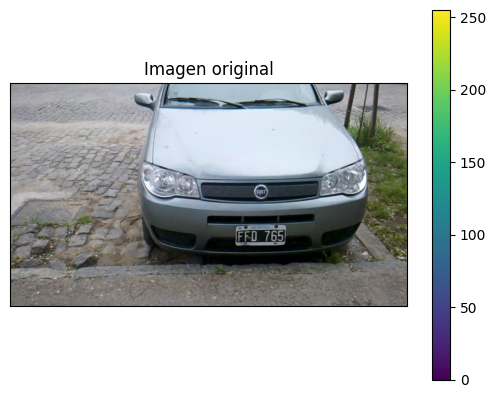

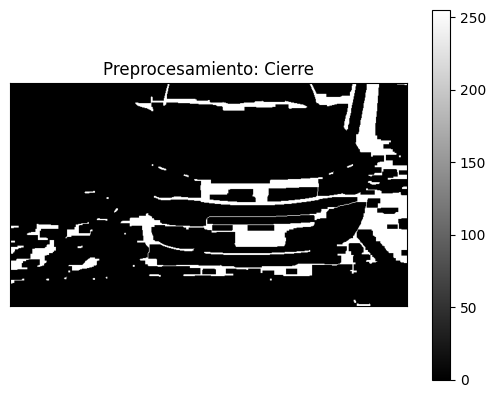

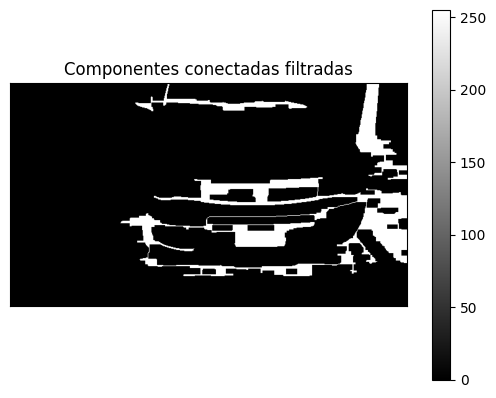

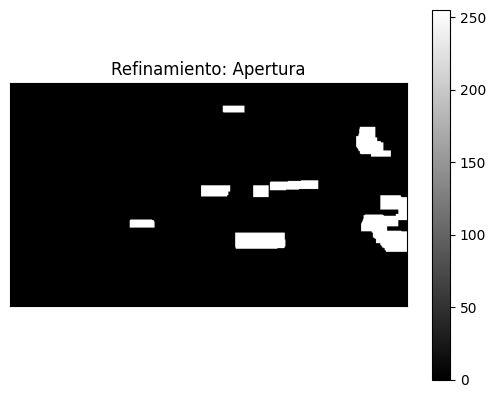

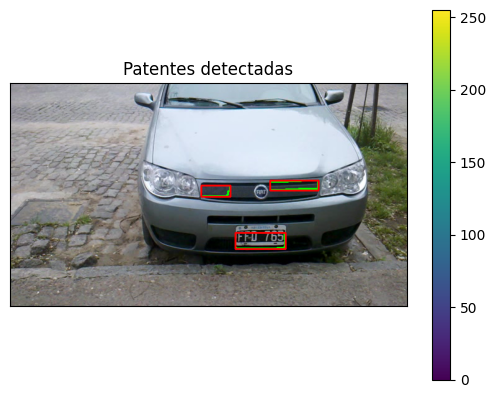

Se encontraron 3 posibles patentes.


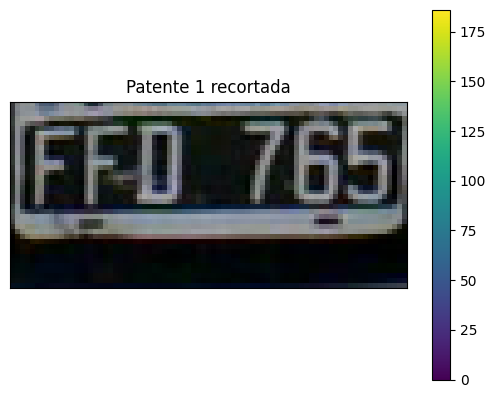

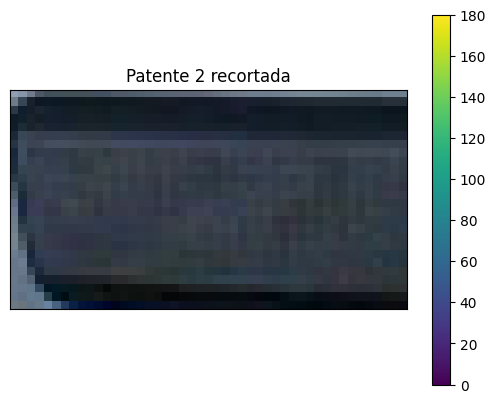

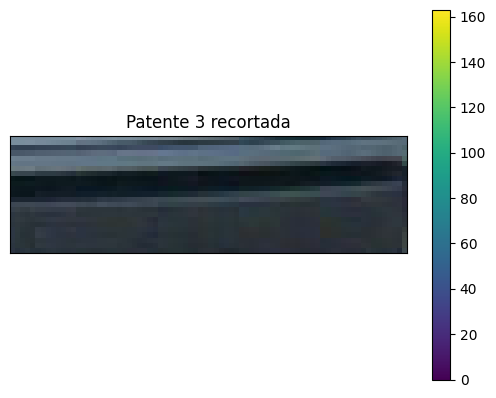

Recorte 1: Área total = 2096.5
Recorte 2: Área total = 778.0
Recorte 3: Área total = 255.0


In [85]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Función para mostrar imágenes
def imshow(img, title=None, color_img=False, colorbar=True, ticks=False):
    plt.figure()
    if color_img:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convierte BGR a RGB para imágenes en color
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    if not ticks:
        plt.xticks([]), plt.yticks([])
    if colorbar:
        plt.colorbar()
    plt.show()

# Función para preprocesar la imagen
def preprocess_image(img, threshold=63, canny_min=200, canny_max=350, kernel_size=(9, 4), iterations=2):
    # Escala de grises y binarización
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, img_bin = cv2.threshold(img_gray, threshold, 255, cv2.THRESH_BINARY)
    
    # Detector de bordes (Canny)
    img_canny = cv2.Canny(img_bin, canny_min, canny_max)
    
    # Operación morfológica de cierre
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    img_close = cv2.morphologyEx(img_canny, cv2.MORPH_CLOSE, kernel, iterations=iterations)
    
    return img_close

# Función para filtrar componentes conectadas
def filter_connected_components(img, min_area=1500):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(img, connectivity=8)
    filtered_img = np.zeros_like(img, dtype=np.uint8)
    
    for i in range(1, num_labels):  # Omite el fondo (etiqueta 0)
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            filtered_img[labels == i] = 255
    
    return filtered_img

# Función para detectar posibles patentes
def encontrar_patentes(img_bin, img, rect_min_size=(42, 11), rect_max_size=(103, 46)):
    ext_contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    posibles_patentes = []
    img_out = img.copy()
    
    height, width = img.shape[:2]
    for contour in ext_contours:
        # Aproximar el contorno a un polígono
        epsilon = 0.045 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # Verificar si es rectangular y cumple con las dimensiones esperadas
        x, y, w, h = cv2.boundingRect(contour)
        if len(approx) == 4 and rect_min_size[0] <= w <= rect_max_size[0] and rect_min_size[1] <= h <= rect_max_size[1]:
            # Recortar la región de la posible patente
            y_start = max(0, y - int(h * 0.3))
            y_end = min(height, y + h + int(h * 0.2))
            patente = img[y_start:y_end, x:x+w]
            posibles_patentes.append(patente)
            
            # Dibujar contorno y rectángulo en la imagen original
            cv2.drawContours(img_out, [contour], -1, (0, 255, 0), 2)
            cv2.rectangle(img_out, (x, y), (x + w, y + h), (0, 0, 255), 2)
    
    imshow(img_out, title="Patentes detectadas", color_img=True)
    return posibles_patentes

# Ajuste para recortar patentes detectadas
def recortar_patentes(posibles_patentes, save_to_disk=False):
    recortes = []
    for i, patente in enumerate(posibles_patentes):
        # Convertir a escala de grises para un procesamiento más preciso (opcional)
        patente_gray = cv2.cvtColor(patente, cv2.COLOR_BGR2GRAY)
        
        # Aplicar un pequeño recorte ajustado a la patente
        x, y, w, h = cv2.boundingRect(cv2.findNonZero(patente_gray))
        recorte = patente[y:y+h, x:x+w]
        recortes.append(recorte)
        
        # Mostrar el recorte
        imshow(recorte, title=f"Patente {i+1} recortada", color_img=True)
        
        """ # Guardar en disco si es necesario
        if save_to_disk:
            filename = f"patente_recortada_{i+1}.png"
            cv2.imwrite(filename, recorte)
            print(f"Patente {i+1} guardada como {filename}")
        """
    return recortes

def mostrar_areas_recortes(posibles_patentes):
    """
    Calcula y muestra el área de cada recorte de patente.
    """
    for i, recorte in enumerate(posibles_patentes):
        # Convertir el recorte a escala de grises para calcular áreas
        recorte_gray = cv2.cvtColor(recorte, cv2.COLOR_BGR2GRAY)
        _, recorte_bin = cv2.threshold(recorte_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        # Calcular el área del contorno más externo
        ext_contours, _ = cv2.findContours(recorte_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        area_total = sum(cv2.contourArea(c) for c in ext_contours)

        # Mostrar el área en consola
        print(f"Recorte {i+1}: Área total = {area_total}")


def main():
    # Leer la imagen
    img_path = 'archivos/img09.png'
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: No se pudo cargar la imagen desde '{img_path}'")
        return

    imshow(img, title="Imagen original", color_img=True)

    # Preprocesamiento
    img_close = preprocess_image(img)
    imshow(img_close, title="Preprocesamiento: Cierre")

    # Filtrar componentes conectadas
    filtered_img = filter_connected_components(img_close)
    imshow(filtered_img, title="Componentes conectadas filtradas")
    
    # Refinamiento con apertura morfológica
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 4))
    img_open = cv2.morphologyEx(filtered_img, cv2.MORPH_OPEN, kernel, iterations=3)
    imshow(img_open, title="Refinamiento: Apertura")
    
    # Detección de patentes
    posibles_patentes = encontrar_patentes(img_open, img)
    print(f"Se encontraron {len(posibles_patentes)} posibles patentes.")
    
    # Recortar patentes detectadas
    recortes = recortar_patentes(posibles_patentes, save_to_disk=True)

    # Mostrar las áreas de los recortes
    mostrar_areas_recortes(recortes)


  
# Ejecutar el programa
if __name__ == "__main__":
    main()

